### Importing Dependencies

In [1]:
import os 
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer,Dense,Normalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

### Checking for GPU

In [2]:
print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
False


### Loading Extracted Features

In [3]:
with open('data.json', 'r') as json_file:
    data = json.load(json_file)

In [4]:
data.keys()

dict_keys(['train', 'val', 'test'])

In [5]:
data['train'].keys()

dict_keys(['feature_vectors', 'labels', 'filepaths', 'class_names'])

In [6]:
print(len(data['train']['feature_vectors']))
print(len(data['val']['feature_vectors']))
print(len(data['test']['feature_vectors']))

1583
203
151


In [7]:
print(len(data['train']['labels']))
print(len(data['val']['labels']))
print(len(data['test']['labels']))

1583
203
151


In [8]:
print(len(data['train']['class_names']))
print(len(data['val']['class_names']))
print(len(data['test']['class_names']))

1583
203
151


In [9]:
print(len(data['train']['filepaths']))
print(len(data['val']['filepaths']))
print(len(data['test']['filepaths']))

1583
203
151


### Data Preprocessing

In [10]:
class_names = ['Azli','British','FordPresident','Kapoor','Obama']

In [11]:
x_train = np.array(data['train']['feature_vectors'])
y_train = np.array(pd.get_dummies(np.array(data['train']['labels'])).astype(int))
print(x_train.shape)
print(y_train.shape)

(1583, 512)
(1583, 5)


In [12]:
x_val = np.array(data['val']['feature_vectors'])
y_val = np.array(pd.get_dummies(np.array(data['val']['labels'])).astype(int))
print(x_val.shape)
print(y_val.shape)

(203, 512)
(203, 5)


In [13]:
x_test = np.array(data['test']['feature_vectors'])
y_test = np.array(pd.get_dummies(np.array(data['test']['labels'])).astype(int))
print(x_test.shape)
print(y_test.shape)

(151, 512)
(151, 5)


### Converting Arrays to Tensors for increasing Computational Efficiency

In [14]:
x_train_t = tf.constant(x_train)
y_train_t = tf.constant(y_train)
print(x_train_t.shape)
print(y_train_t.shape)

(1583, 512)
(1583, 5)


In [15]:
x_val_t = tf.constant(x_val)
y_val_t = tf.constant(y_val)
print(x_val_t.shape)
print(y_val_t.shape)

(203, 512)
(203, 5)


In [16]:
x_test_t = tf.constant(x_test)
y_test_t = tf.constant(y_test)
print(x_test_t.shape)
print(y_test_t.shape)

(151, 512)
(151, 5)


### Using Tensorflow Data Pipelines for efficient Data Ingestion for scalability

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(64).prefetch(tf.data.AUTOTUNE)

In [18]:
for x_batch, y_batch in train_dataset:
    print("Input shape:", x_batch.shape)
    print("Output shape:", y_batch.shape)
    break  # Stop after the first batch

Input shape: (64, 512)
Output shape: (64, 5)


In [19]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(64).prefetch(tf.data.AUTOTUNE)

In [20]:
for x_batch, y_batch in val_dataset:
    print("Input shape:", x_batch.shape)
    print("Output shape:", y_batch.shape)
    break  # Stop after the first batch

Input shape: (64, 512)
Output shape: (64, 5)


In [21]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
for x_batch, y_batch in test_dataset:
    print("Input shape:", x_batch.shape)
    print("Output shape:", y_batch.shape)
    break  # Stop after the first batch

Input shape: (32, 512)
Output shape: (32, 5)


### Defining Model

In [23]:
input_dim = 512
num_classes = 5

In [24]:
model = Sequential()
model.add(InputLayer(input_shape=(input_dim,)))
model.add(Normalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 512)               1025      
 on)                                                             
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [27]:
early_stopping = EarlyStopping(monitor='val_loss',patience=20,verbose=1,restore_best_weights=True)

### Training Model

In [28]:
history = model.fit(train_dataset,validation_data = val_dataset,epochs = 100,verbose = 1,callbacks = [early_stopping])

Epoch 1/100


25/25 [==============================] - 1s 15ms/step - loss: 3.3563 - accuracy: 0.2160 - val_loss: 1.6162 - val_accuracy: 0.1970
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 1.6998 - accuracy: 0.0499 - val_loss: 1.6058 - val_accuracy: 0.1970
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 1.6473 - accuracy: 0.0430 - val_loss: 1.6041 - val_accuracy: 0.2414
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 1.6070 - accuracy: 0.1213 - val_loss: 1.5735 - val_accuracy: 0.3941
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 1.5423 - accuracy: 0.4555 - val_loss: 1.6397 - val_accuracy: 0.1970
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 1.7230 - accuracy: 0.0461 - val_loss: 1.5022 - val_accuracy: 0.2611
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 1.5182 - accuracy: 0.3487 - val_loss: 1.3837 - val_accuracy: 0.4187
Epoch 8/10

25/25 [==============================] - 0s 15ms/step - loss: 0.5507 - accuracy: 0.7416 - val_loss: 0.8888 - val_accuracy: 0.7734
Epoch 56/100
25/25 [==============================] - 0s 12ms/step - loss: 0.5346 - accuracy: 0.7517 - val_loss: 0.8396 - val_accuracy: 0.7833
Epoch 57/100
25/25 [==============================] - 0s 15ms/step - loss: 0.5272 - accuracy: 0.7517 - val_loss: 0.8308 - val_accuracy: 0.7734
Epoch 58/100
25/25 [==============================] - 0s 14ms/step - loss: 0.5011 - accuracy: 0.7637 - val_loss: 0.8141 - val_accuracy: 0.7980
Epoch 59/100
25/25 [==============================] - 0s 15ms/step - loss: 0.5179 - accuracy: 0.7555 - val_loss: 2.4522 - val_accuracy: 0.6502
Epoch 60/100
25/25 [==============================] - 0s 12ms/step - loss: 1.0051 - accuracy: 0.6393 - val_loss: 1.3094 - val_accuracy: 0.5714
Epoch 61/100
25/25 [==============================] - 0s 14ms/step - loss: 1.2819 - accuracy: 0.5401 - val_loss: 1.9043 - val_accuracy: 0.2512
Epoch 62/100

### Model Evaluation

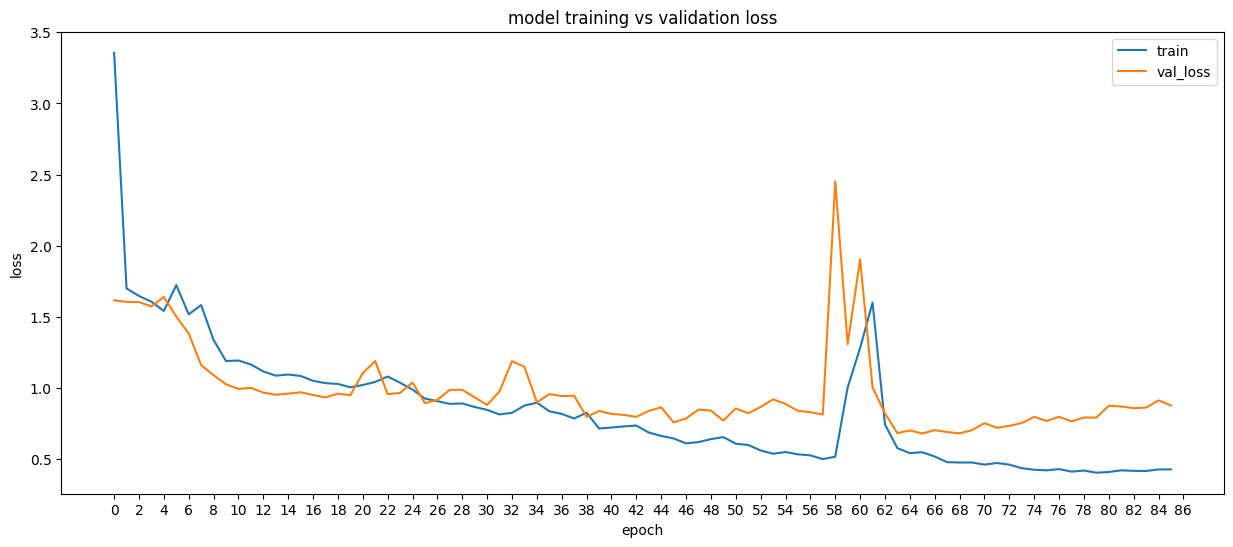

In [32]:
# model training evaluation
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0, len(history.history['accuracy'])+1, 2))
plt.legend(['train','val_loss'])
plt.show()

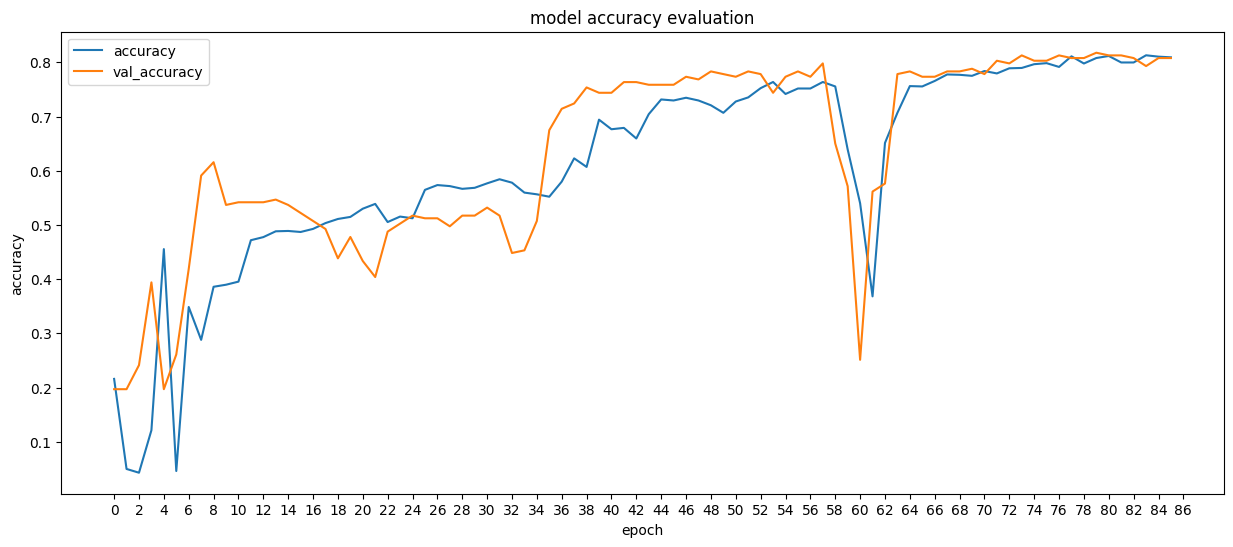

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy evaluation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0, len(history.history['accuracy'])+1, 2))
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [34]:
model.evaluate(test_dataset)

7/7 [==============================] - 0s 2ms/step - loss: 0.6810 - accuracy: 0.7734


[0.6809600591659546, 0.7733989953994751]

### Saving Model

In [35]:
model.save('model.h5')